# S&P 500 Company Correlation Table

In [19]:
import bs4 as bs
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web
import pickle
import requests
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot') # allows you to use the 'ggplot' style package within matplotlib

def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml') #grabs all text data of the source code
    table = soup.find('table', {'class':'wikitable sortable'}) #grabs all table data from with the HTML class of wikitable sortable
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.replace('.', '-')
        ticker= ticker[:-1]
        tickers.append(ticker)
    
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    
    return tickers

def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    
    else:
         with open("sp500tickers.pickle", "rb") as f:
                tickers = pickle.load(f)
    
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    start = dt.datetime(2000, 1, 1)
    end = dt.datetime.now()
    
    for ticker in tickers:
        print(ticker)
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'yahoo', start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))
            
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)
        
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        
        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
        
        if count % 10 == 0:
            print(count)
    
    print(main_df.head())
    main_df.to_csv('sp500_joined_adjCloses.csv')

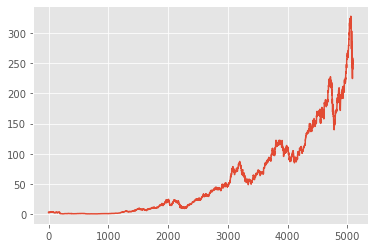

In [14]:
def visualize_data():
    df = pd.read_csv("sp500_joined_adjCloses.csv")
    df['AAPL'].plot()
    
visualize_data()

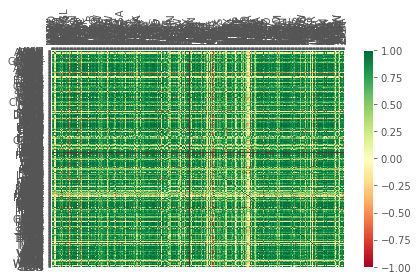

In [18]:
def visualize_data():
    df = pd.read_csv("sp500_joined_adjCloses.csv")
    df_corr = df.corr()

    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn) # pcolor creates a pseudocolored plot with a non-regular rectangular grid
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top() #sets the x axis ticks on the top
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    
    
visualize_data()

- np.arange(data.shape[0]): creates a range of ticks through numpy through the .shape[] method, which specifies the dimension value of a nxm matrix/array (.shape[0] is the n value and .shape[1] is the m value). '+ 0.5' is to set the ticks 0.5 further to the right so that it is at the center of each company tick



- ax.invert_yaxis(): this method allows you to flip the y-axis from smallest to largest to becoming largest to smallest. In this case, since the x-axis is at the top of the correlation graph, the y-axis will be flipped so that the r-value will be one at the square intersection of the same company ticks



- plt.xticks(rotation=90): rotates each tick on the x axis 90 degrees for it to be readable



- heatmap.set_clim(-1, 1): set the color limits at specific value ends, -1 and 1 being the two ends of the r-value spectrum



- plt.tight_layout(): sets a tight layout for the correlation table